# Preliminary operations

## Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/Homework2

[Errno 2] No such file or directory: 'gdrive/MyDrive/Homework2'
/content/gdrive/.shortcut-targets-by-id/18l1rfUZ0RyCJPiDTcoMfRf-FljJFv22e/Homework2


In [ ]:
!ls

'1. Data preparation.ipynb'   hp		 scalers
'2. CNN.ipynb'		      models		 Spettrogramma.ipynb
'2. CNN no scaler.ipynb'      Notes.gdoc	 training_dataset_homework2.zip
 Ensamble.ipynb		      original_dataset


## Libraries and seed

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,  StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.utils import  compute_class_weight
!pip install scikeras 
from scikeras.wrappers import KerasClassifier

!pip install keras-tuner -q
import keras_tuner

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Functions definition

In [ ]:
def data_processing(data, target):

  X_train_val, X_test, y_train_val, y_test = train_test_split(data, target, test_size = 0.1, random_state=seed, stratify=target)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state=seed, stratify=y_train_val)

  scaler = RobustScaler()
  scaler = scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
  pickle.dump(scaler, open('scalers/robustscaler.sav', 'wb'))

  ss = pickle.load(open('scalers/robustscaler.sav', 'rb'))
  X_train_scaled = ss.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_val_scaled = ss.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
  X_test_scaled = ss.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

  y_train_cat = tf.keras.utils.to_categorical(y_train)
  y_val_cat = tf.keras.utils.to_categorical(y_val)
  y_test_cat = tf.keras.utils.to_categorical(y_test)

  print(X_train_scaled.shape, y_train.shape, y_train_cat.shape)
  print(X_val_scaled.shape, y_val.shape, y_val_cat.shape)
  print(X_test_scaled.shape, y_test.shape, y_test_cat.shape)


  return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat

In [ ]:
def evaluate_model_f(file_name, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from file """
  
  model = tfk.models.load_model(file_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": file_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

In [ ]:
def evaluate_model_m(model, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from trained model variable """
  
  predictions = model.predict(test_set)
  metrics= {
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(15,15))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

# Data preparation

```
Time series:
  n. observations: 2429
  observation's length: 36 samples
  n. channel per observation: 6

Number of classes: 12
```



In [ ]:
data = np.load('original_dataset/x_train.npy')
target = np.load('original_dataset/y_train.npy')
print(data.shape)
print(target.shape)

(2429, 36, 6)
(2429,)


In [ ]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat= data_processing(data, target)

(1967, 36, 6) (1967,) (1967, 12)
(219, 36, 6) (219,) (219, 12)
(243, 36, 6) (243,) (243, 12)


In [ ]:
classes = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"
}

# Signals as images - first attempt

In [ ]:
X_train = X_train_scaled
y_train_l = y_train
y_train = y_train_cat
X_val = X_val_scaled
y_val = y_val_cat
X_test = X_test_scaled
y_test = y_test_cat
input_shape = X_train.shape[1:]
n_output = y_train.shape[-1]
target_shape = (input_shape[0], input_shape[1],1)
new_size = 36
final_shape = (new_size,new_size, 3)

batch_size= 128
epochs= 200

print(input_shape)
print(target_shape)
print(final_shape)
print(n_output)

(36, 6)
(36, 6, 1)
(36, 36, 3)
12


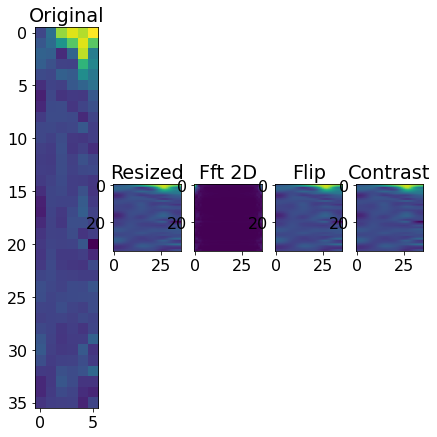

In [ ]:
proc = tfkl.Resizing(new_size,new_size, interpolation="bicubic")(X_train[0].reshape(target_shape))
proc2 = tf.convert_to_tensor(np.power(abs((np.fft.fft2(proc.numpy()))),1))
proc3 = tfkl.RandomContrast(1)(proc)
proc4 = tfkl.RandomFlip()(proc)

plt.figure(figsize=(7,7))
plot_a = plt.subplot(151)
plot_a.set_title('Original')
plot_a.imshow(X_train[0])

plot_b = plt.subplot(152)
plot_b.set_title('Resized')
plot_b.imshow(proc[:,:,0])

plot_c = plt.subplot(153)
plot_c.set_title('Fft 2D')
plot_c.imshow(proc2[:,:,0])

plot_d = plt.subplot(154)
plot_d.set_title('Flip')
plot_d.imshow(proc4[:,:,0])

plot_e = plt.subplot(155)
plot_e.set_title('Contrast')
plot_e.imshow(proc3[:,:,0])


In [ ]:
def build_effnet(dp_rate1=0.3, dp_rate2=0.3, nc=512, elastic_lambda= 1e-3,  lr = 1e-3):


  supernet = tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=final_shape,
    pooling='avg',
    include_preprocessing=True)

  # Use the supernet as feature extractor
  supernet.trainable = True

  inputs = tfk.Input(shape=input_shape)
  x= tfkl.Reshape(target_shape)(inputs)
  x = tfkl.Resizing(new_size,new_size, interpolation="bicubic")(x) #'bilinear', 'nearest', 'bicubic', 'area', 'lanczos3', 'lanczos5', 'gaussian', 'mitchellcubic'
  
  #x1 = tfkl.RandomBrightness(1)(tfkl.RandomContrast(1)(x)) 
  x1 = tfkl.RandomContrast(1)(x) 
  x2 = tfkl.RandomFlip()(x) 
  #x2 = tf.reshape(tf.convert_to_tensor(np.power(abs((np.fft.fft2(tf.make_ndarray(tf.make_tensor_proto(x))))),1)), tf.shape(x)) 
  #x2 = tfkl.RandomBrightness(1)(x)

  x = tf.keras.layers.Concatenate(axis=-1)([x, x1, x2])
  x = supernet(x)
  x = tfkl.Dropout(dp_rate1, seed=seed)(x)   
  x = tfkl.Dense( 
      units=nc, 
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
  x=tfkl.LeakyReLU()(x)
  x = tfkl.Dropout(dp_rate2, seed=seed)(x)  
  outputs = tfkl.Dense(
      n_output, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
  tl_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=lr,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07),
  loss="categorical_crossentropy",
  metrics=["accuracy"],
  )
  return tl_model

In [ ]:
batch_size = 128
epochs = 200

model = build_effnet(
    dp_rate1=0.4, 
    dp_rate2=0.4, 
    nc=64, 
    elastic_lambda= 1e-3,  
    lr = 1e-3)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 36, 6)]      0           []                               
                                                                                                  
 reshape_6 (Reshape)            (None, 36, 6, 1)     0           ['input_14[0][0]']               
                                                                                                  
 resizing_14 (Resizing)         (None, 36, 36, 1)    0           ['reshape_6[0][0]']              
                                                                                                  
 random_contrast_14 (RandomCont  (None, 36, 36, 1)   0           ['resizing_14[0][0]']            
 rast)                                                                                        

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val, y_val),
    #class_weight = dict(zip(np.unique(y_train_l), compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_l), y = y_train_l))),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200


16/16 [==============================] - 50s 1s/step - loss: 4.8780 - accuracy: 0.3050 - val_loss: 4.3680 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 17s 1s/step - loss: 4.0164 - accuracy: 0.4535 - val_loss: 4.0163 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 17s 1s/step - loss: 3.4953 - accuracy: 0.4789 - val_loss: 3.4984 - val_accuracy: 0.4749 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 17s 1s/step - loss: 3.0239 - accuracy: 0.5343 - val_loss: 3.6241 - val_accuracy: 0.3470 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 18s 1s/step - loss: 2.5047 - accuracy: 0.5811 - val_loss: 3.3027 - val_accuracy: 0.3744 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 18s 1s/step - loss: 2.1886 - accuracy: 0.5938 - val_loss: 3.6193 - val_accuracy: 0.2740 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 17s 1s/step - loss: 1.8831 - accura

In [ ]:
model.save('models/Effnet6')

In [ ]:
eff = tfk.models.load_model('models/Effnet6')

62/62 [==============================] - 4s 24ms/step
Accuracy: 0.938485002541942
F1 score: 0.9167750263473263


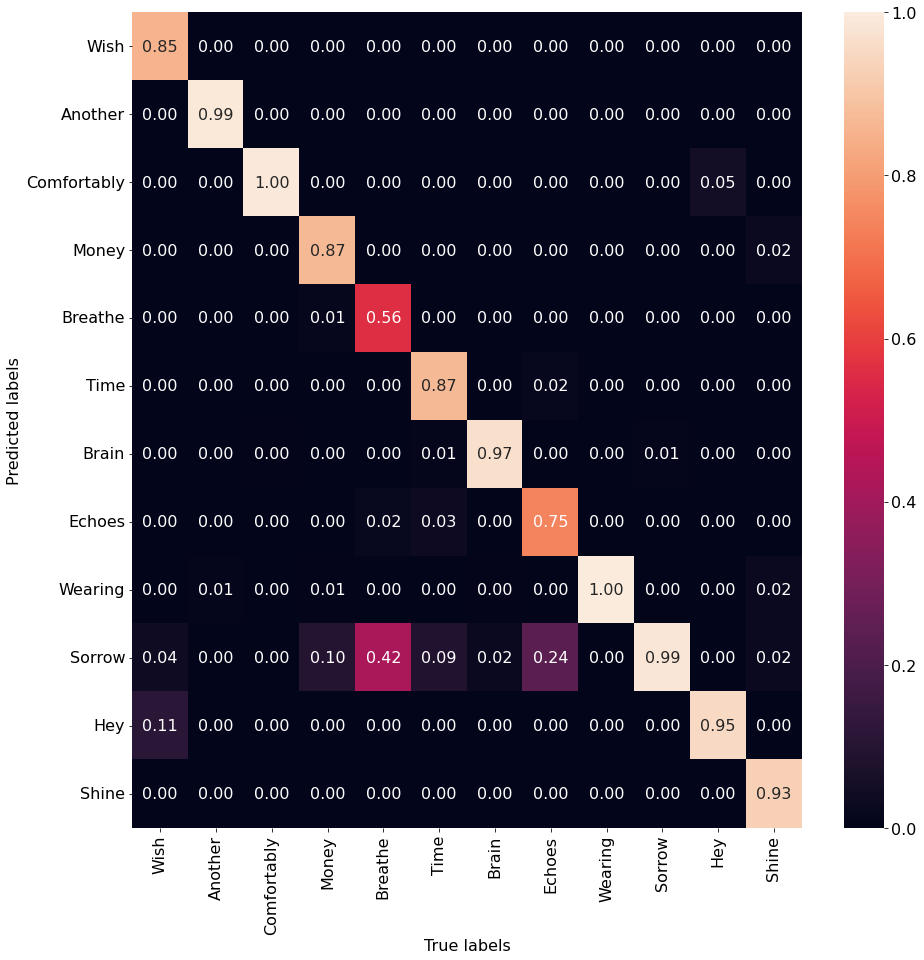

7/7 [==============================] - 0s 22ms/step
Accuracy: 0.7123287671232876
F1 score: 0.6050281841639445


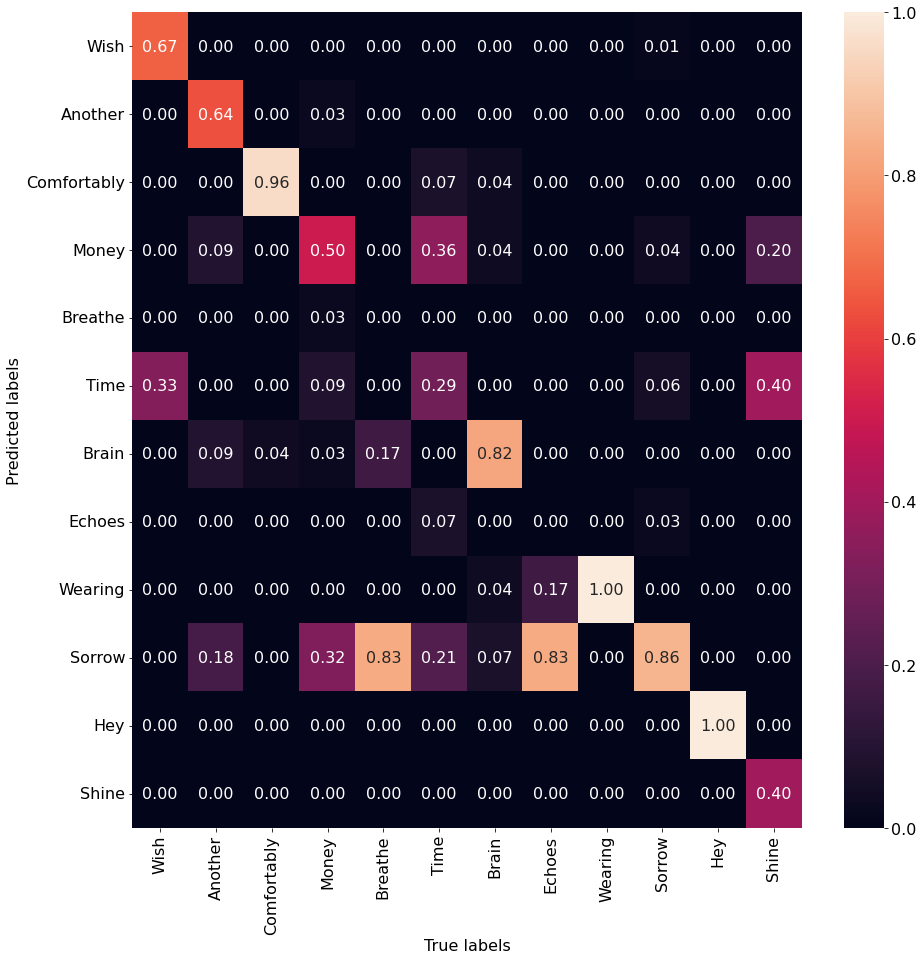

8/8 [==============================] - 0s 24ms/step
Accuracy: 0.6954732510288066
F1 score: 0.610562723428565


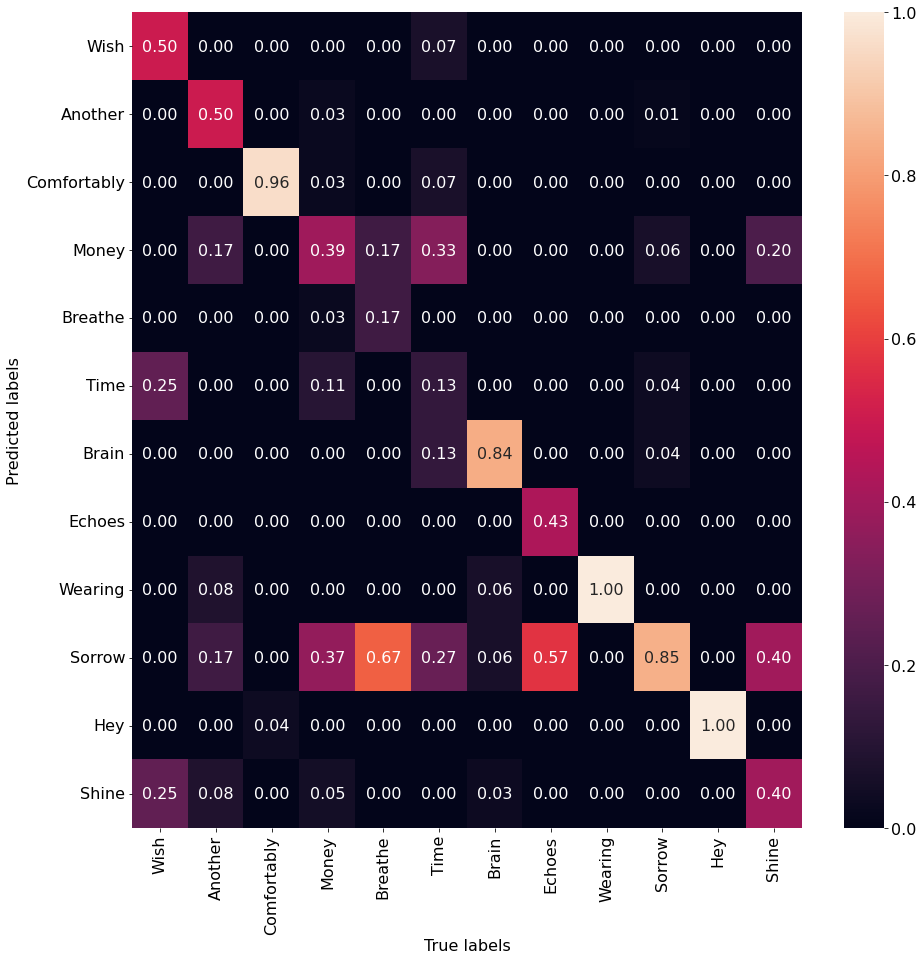

In [ ]:
ret = evaluate_model_m(eff, X_train, y_train, classes)
ret = evaluate_model_m(eff, X_val, y_val, classes)
ret = evaluate_model_m(eff, X_test, y_test, classes)

# Signals as images - second attempt

In [ ]:
input_shape = X_train.shape[1:]
n_output = y_train.shape[-1]
new_size = 32 
target_shape = (72,3,1)
final_shape = (32,32,3)

batch_size= 128
epochs= 200

print(input_shape)
print(n_output)

(72, 3)
12


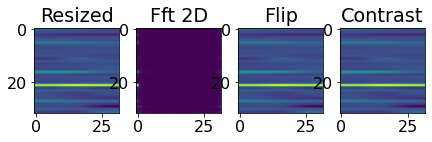

In [ ]:
proc = tfkl.Resizing(new_size,new_size, interpolation="bicubic")(X_train[0].reshape(target_shape)) #'bilinear', 'nearest', 'bicubic', 'area', 'lanczos3', 'lanczos5', 'gaussian', 'mitchellcubic'
proc2 = tf.convert_to_tensor(np.power(abs((np.fft.fft2(proc.numpy()))),1))
proc3 = tfkl.RandomContrast(1)(proc)
proc4 = tfkl.RandomFlip(mode="vertical")(proc)

plt.figure(figsize=(7,7))

plot_b = plt.subplot(141)
plot_b.set_title('Resized')
plot_b.imshow(proc[:,:,0])

plot_c = plt.subplot(142)
plot_c.set_title('Fft 2D')
plot_c.imshow(proc2[:,:,0])

plot_d = plt.subplot(143)
plot_d.set_title('Flip')
plot_d.imshow(proc4[:,:,0])

plot_e = plt.subplot(144)
plot_e.set_title('Contrast')
plot_e.imshow(proc3[:,:,0])


In [ ]:
def build_effnet(dp_rate1=0.3, dp_rate2=0.3, nc=512, elastic_lambda= 1e-3,  lr = 1e-3):

  supernet = tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=final_shape,
    pooling='avg',
    include_preprocessing=True)

  # Use the supernet as feature extractor
  supernet.trainable = True

  inputs = tfk.Input(shape=input_shape)
  x= tfkl.Reshape(target_shape)(inputs)
  x = tfkl.Resizing(new_size,new_size, interpolation="bicubic")(x) #'bilinear', 'nearest', 'bicubic', 'area', 'lanczos3', 'lanczos5', 'gaussian', 'mitchellcubic'
  
  x1 = tfkl.RandomContrast(1)(x) 
  x2 = tfkl.RandomFlip(mode="vertical")(x) 

  x = tf.keras.layers.Concatenate(axis=-1)([x, x1, x2])
  x = supernet(x)
  x = tfkl.Dropout(dp_rate1, seed=seed)(x)   
  x = tfkl.Dense( 
      units=nc, 
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
  x=tfkl.LeakyReLU()(x)
  x = tfkl.Dropout(dp_rate2, seed=seed)(x)  
  outputs = tfkl.Dense(
      n_output, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
  tl_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=lr,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07),
  loss="categorical_crossentropy",
  metrics=["accuracy"],
  )
  return tl_model

In [ ]:
batch_size = 128
epochs = 200

model = build_effnet(
    dp_rate1=0.4, 
    dp_rate2=0.4, 
    nc=64, 
    elastic_lambda= 1e-3,  
    lr = 1e-3)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 72, 3)]      0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 72, 3, 1)     0           ['input_6[0][0]']                
                                                                                                  
 resizing_8 (Resizing)          (None, 32, 32, 1)    0           ['reshape_4[0][0]']              
                                                                                                  
 random_contrast_6 (RandomContr  (None, 32, 32, 1)   0           ['resizing_8[0][0]']             
 ast)                                                                                         

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val, y_val),
    class_weight = dict(zip(np.unique(y_train_l), compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_l), y = y_train_l))),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200


16/16 [==============================] - 37s 1s/step - loss: 5.2785 - accuracy: 0.1134 - val_loss: 4.8995 - val_accuracy: 0.1370 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 16s 972ms/step - loss: 4.7283 - accuracy: 0.1566 - val_loss: 4.7216 - val_accuracy: 0.1005 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 16s 967ms/step - loss: 4.2072 - accuracy: 0.1617 - val_loss: 5.4023 - val_accuracy: 0.0822 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 16s 965ms/step - loss: 3.8730 - accuracy: 0.1927 - val_loss: 4.8140 - val_accuracy: 0.0822 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 16s 975ms/step - loss: 3.4700 - accuracy: 0.2089 - val_loss: 3.8017 - val_accuracy: 0.0731 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 16s 987ms/step - loss: 3.1485 - accuracy: 0.2161 - val_loss: 3.4016 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 16s 982ms/step - los

In [ ]:
model.save('models/Effnet6')

In [ ]:
eff = tfk.models.load_model('models/Effnet6')

62/62 [==============================] - 4s 24ms/step
Accuracy: 0.938485002541942
F1 score: 0.9167750263473263


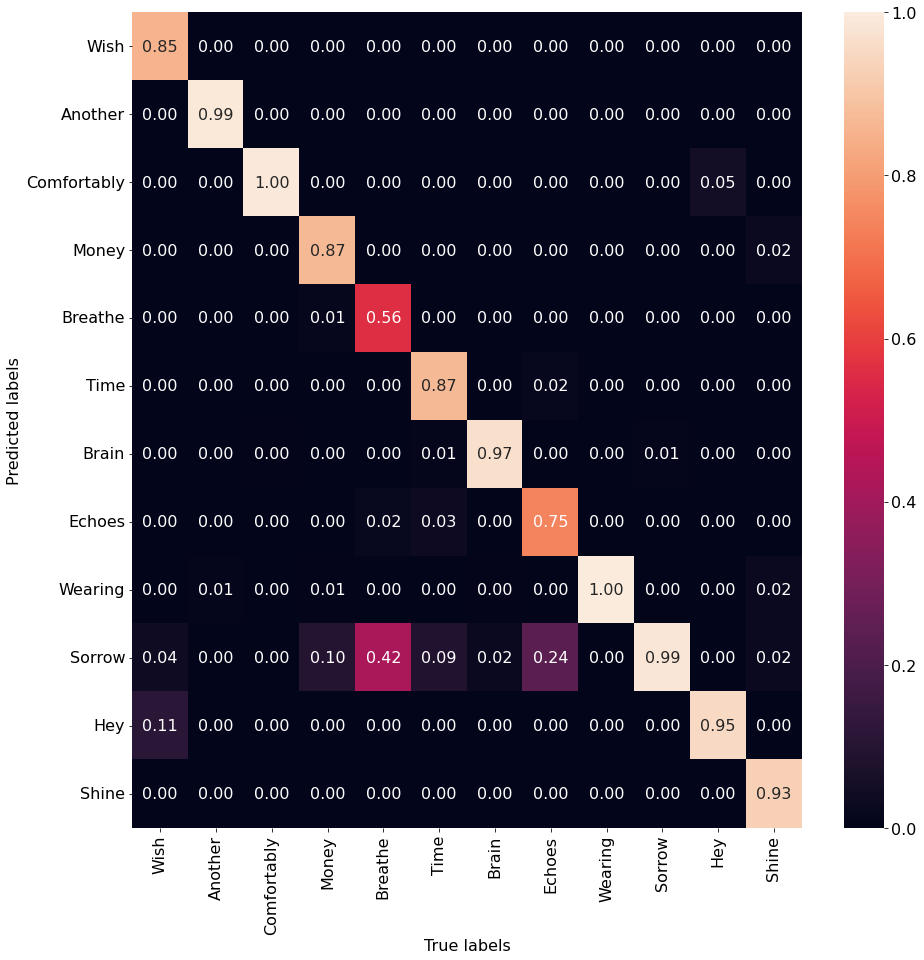

7/7 [==============================] - 0s 22ms/step
Accuracy: 0.7123287671232876
F1 score: 0.6050281841639445


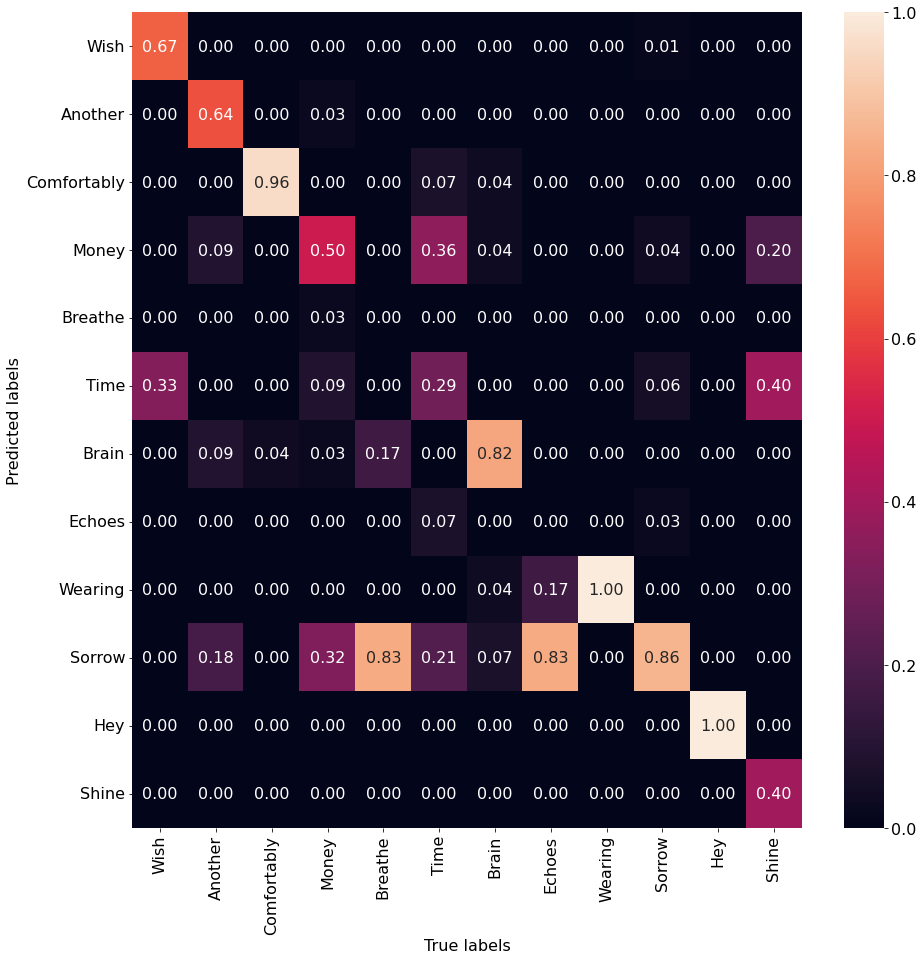

8/8 [==============================] - 0s 24ms/step
Accuracy: 0.6954732510288066
F1 score: 0.610562723428565


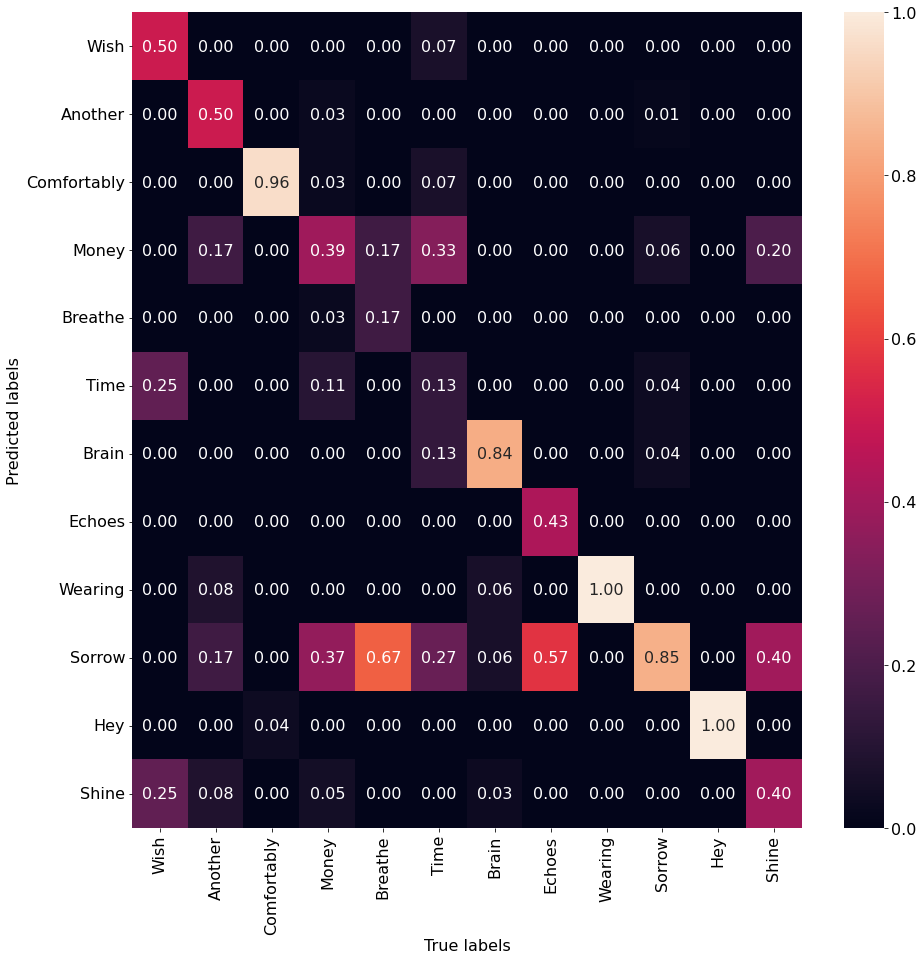

In [ ]:
ret = evaluate_model_m(eff, X_train, y_train, classes)
ret = evaluate_model_m(eff, X_val, y_val, classes)
ret = evaluate_model_m(eff, X_test, y_test, classes)

# Spectrogram

In [ ]:
def to_spectrogram_tensor(X_orig, nfft):
  X = None
  for x in X_orig:
    if tf.is_tensor(x): x.numpy()
    pp, ff, tt, pplot = pylab.specgram(x, NFFT=nfft, Fs=1, detrend=pylab.detrend, window=pylab.window_hanning, noverlap=nfft-(nfft/10))
    pp= tf.expand_dims(tf.convert_to_tensor(pp), axis=-1)
    tensor = tf.expand_dims(pp, axis=0)
    if (X is None): X= tensor
    else: X = tf.concat([X, tensor], 0)
  return X

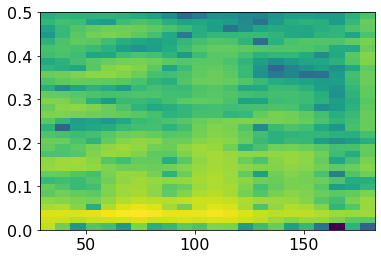

In [ ]:
nfft= 64
X_train = to_spectrogram_tensor(X_train,nfft)
X_val = to_spectrogram_tensor(X_val,nfft)
X_test = to_spectrogram_tensor(X_test,nfft)

In [ ]:
y_train_l = y_train
y_train = y_train_cat
y_val = y_val_cat
y_test = y_test_cat

# Model

In [ ]:
X_train=X_train.numpy()
X_val=X_val.numpy()
X_test=X_test.numpy()

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
# print(tf.shape(X_train))
# print(tf.shape(X_val))
# print(tf.shape(X_test))

(1967, 33, 22, 1)
(219, 33, 22, 1)
(243, 33, 22, 1)


In [ ]:
input_shape = (33,22,1)
final_shape = (32,32,3)
n_output = y_train.shape[-1]

batch_size= 128
epochs= 200

In [ ]:
def build_effnet(dp_rate1=0.3, dp_rate2=0.3, nc=512, elastic_lambda= 1e-3,  lr = 1e-3):

  supernet = tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=final_shape,
    pooling='avg',
    include_preprocessing=True)

  # Use the supernet as feature extractor
  supernet.trainable = True

  inputs = tfk.Input(shape=input_shape)
  x = tf.keras.layers.Conv2D(3,2, padding='same',kernel_initializer='glorot_uniform')(inputs)
  x = tfkl.Resizing(32,32, interpolation="bicubic")(x) #'bilinear', 'nearest', 'bicubic', 'area', 'lanczos3', 'lanczos5', 'gaussian', 'mitchellcubic'

  x = supernet(x)
  x = tfkl.Dropout(dp_rate1, seed=seed)(x)   
  x = tfkl.Dense( 
      units=nc, 
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
  x=tfkl.LeakyReLU()(x)
  x = tfkl.Dropout(dp_rate2, seed=seed)(x)  
  outputs = tfkl.Dense(
      n_output, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
  tl_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=lr,
    rho=0.9,
    momentum=0.03,
    epsilon=1e-07),
  loss="categorical_crossentropy",
  metrics=["accuracy"],
  )
  return tl_model

Find the best hyperparameter configuration

In [ ]:
# model class to use in the scikit parameter search CV 
model = KerasClassifier(build_fn=build_effnet, dp_rate1=0.3, dp_rate2=0.3, nc=512, elastic_lambda= 1e-3,  lr = 1e-3)

In [ ]:
# define the hyperparameters to tune
hyperparameters = {
    'epochs': np.arange(30, 70, 10),
    'batch_size': [32, 64, 128],
    'nc': np.arange(64, 512, 2),
    'lr': [1e-2,1e-3,1e-4,1e-5], 
    'elastic_lambda':[1e-2, 1e-3, 1e-4,1e-5],
    'dp_rate1': np.arange(0, 0.5, 0.05),
    'dp_rate2': np.arange(0, 0.5, 0.05)
}

In [ ]:
# create the random search object
rs = BayesSearchCV(estimator=model, search_spaces=hyperparameters, cv=2, n_iter=10)

In [ ]:
# fit the random search object to the training data
rs.fit(X_train, y_train)

# view the best hyperparameters
print(rs.best_params_)

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


82420632/82420632 [==============================] - 3s 0us/step
Epoch 1/50
16/16 [==============================] - 35s 157ms/step - loss: 3.4857 - accuracy: 0.1638
Epoch 2/50
16/16 [==============================] - 1s 93ms/step - loss: 3.2162 - accuracy: 0.2777
Epoch 3/50
16/16 [==============================] - 1s 92ms/step - loss: 3.1240 - accuracy: 0.2960
Epoch 4/50
16/16 [==============================] - 2s 94ms/step - loss: 3.0903 - accuracy: 0.3011
Epoch 5/50
16/16 [==============================] - 2s 94ms/step - loss: 3.0736 - accuracy: 0.3103
Epoch 6/50
16/16 [==============================] - 2s 94ms/step - loss: 3.0331 - accuracy: 0.3164
Epoch 7/50
16/16 [==============================] - 2s 94ms/step - loss: 3.0673 - accuracy: 0.3133
Epoch 8/50
16/16 [==============================] - 2s 97ms/step - loss: 3.0139 - accuracy: 0.3255
Epoch 9/50
16/16 [==============================] - 1s 93ms/step - loss: 3.0044 - accuracy: 0.3388
Epoch 10/50
16/16 [=======================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
16/16 [==============================] - 22s 135ms/step - loss: 3.6563 - accuracy: 0.1006
Epoch 2/50
16/16 [==============================] - 2s 96ms/step - loss: 3.3805 - accuracy: 0.2043
Epoch 3/50
16/16 [==============================] - 2s 97ms/step - loss: 3.2575 - accuracy: 0.2703
Epoch 4/50
16/16 [==============================] - 2s 97ms/step - loss: 3.1648 - accuracy: 0.3008
Epoch 5/50
16/16 [==============================] - 2s 96ms/step - loss: 3.1497 - accuracy: 0.3028
Epoch 6/50
16/16 [==============================] - 2s 99ms/step - loss: 3.1346 - accuracy: 0.3039
Epoch 7/50
16/16 [==============================] - 2s 97ms/step - loss: 3.1078 - accuracy: 0.3100
Epoch 8/50
16/16 [==============================] - 2s 97ms/step - loss: 3.0722 - accuracy: 0.3293
Epoch 9/50
16/16 [==============================] - 2s 98ms/step - loss: 3.0655 - accuracy: 0.3211
Epoch 10/50
16/16 [==============================] - 2s 96ms/step - loss: 3.0610 - accuracy: 0.3171
Epoch 1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/60
8/8 [==============================] - 23s 288ms/step - loss: 60.4805 - accuracy: 0.1017
Epoch 2/60
8/8 [==============================] - 1s 109ms/step - loss: 60.2591 - accuracy: 0.0916
Epoch 3/60
8/8 [==============================] - 1s 106ms/step - loss: 60.0490 - accuracy: 0.0977
Epoch 4/60
8/8 [==============================] - 1s 106ms/step - loss: 59.8807 - accuracy: 0.1089
Epoch 5/60
8/8 [==============================] - 1s 105ms/step - loss: 59.7219 - accuracy: 0.1099
Epoch 6/60
8/8 [==============================] - 1s 106ms/step - loss: 59.5484 - accuracy: 0.0987
Epoch 7/60
8/8 [==============================] - 1s 105ms/step - loss: 59.4075 - accuracy: 0.1200
Epoch 8/60
8/8 [==============================] - 1s 103ms/step - loss: 59.2789 - accuracy: 0.1078
Epoch 9/60
8/8 [==============================] - 1s 105ms/step - loss: 59.1156 - accuracy: 0.1312
Epoch 10/60
8/8 [==============================] - 1s 106ms/step - loss: 58.9996 - accuracy: 0.1129
Epoch 11

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/60
8/8 [==============================] - 20s 225ms/step - loss: 60.3899 - accuracy: 0.1098
Epoch 2/60
8/8 [==============================] - 1s 103ms/step - loss: 60.1266 - accuracy: 0.1067
Epoch 3/60
8/8 [==============================] - 1s 107ms/step - loss: 59.9225 - accuracy: 0.1047
Epoch 4/60
8/8 [==============================] - 1s 109ms/step - loss: 59.7265 - accuracy: 0.1087
Epoch 5/60
8/8 [==============================] - 1s 103ms/step - loss: 59.5992 - accuracy: 0.1291
Epoch 6/60
8/8 [==============================] - 1s 103ms/step - loss: 59.3884 - accuracy: 0.1280
Epoch 7/60
8/8 [==============================] - 1s 105ms/step - loss: 59.2590 - accuracy: 0.1128
Epoch 8/60
8/8 [==============================] - 1s 105ms/step - loss: 59.1465 - accuracy: 0.1209
Epoch 9/60
8/8 [==============================] - 1s 104ms/step - loss: 58.9785 - accuracy: 0.1240
Epoch 10/60
8/8 [==============================] - 1s 105ms/step - loss: 58.8115 - accuracy: 0.1423
Epoch 11

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/40
16/16 [==============================] - 20s 98ms/step - loss: 3.0080 - accuracy: 0.2482
Epoch 2/40
16/16 [==============================] - 2s 96ms/step - loss: 2.8980 - accuracy: 0.2808
Epoch 3/40
16/16 [==============================] - 2s 96ms/step - loss: 2.7711 - accuracy: 0.3103
Epoch 4/40
16/16 [==============================] - 2s 110ms/step - loss: 2.7020 - accuracy: 0.3276
Epoch 5/40
16/16 [==============================] - 2s 138ms/step - loss: 2.6279 - accuracy: 0.3306
Epoch 6/40
16/16 [==============================] - 2s 108ms/step - loss: 2.6125 - accuracy: 0.3367
Epoch 7/40
16/16 [==============================] - 2s 98ms/step - loss: 2.6174 - accuracy: 0.3235
Epoch 8/40
16/16 [==============================] - 2s 96ms/step - loss: 2.5945 - accuracy: 0.3428
Epoch 9/40
16/16 [==============================] - 2s 95ms/step - loss: 2.5905 - accuracy: 0.3347
Epoch 10/40
16/16 [==============================] - 2s 96ms/step - loss: 2.5714 - accuracy: 0.3428
Epoch

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/40
16/16 [==============================] - 21s 100ms/step - loss: 3.0903 - accuracy: 0.1667
Epoch 2/40
16/16 [==============================] - 2s 100ms/step - loss: 2.9120 - accuracy: 0.2520
Epoch 3/40
16/16 [==============================] - 2s 99ms/step - loss: 2.8152 - accuracy: 0.2896
Epoch 4/40
16/16 [==============================] - 2s 99ms/step - loss: 2.7237 - accuracy: 0.3150
Epoch 5/40
16/16 [==============================] - 2s 101ms/step - loss: 2.7108 - accuracy: 0.3191
Epoch 6/40
16/16 [==============================] - 2s 99ms/step - loss: 2.7142 - accuracy: 0.3191
Epoch 7/40
16/16 [==============================] - 2s 98ms/step - loss: 2.6734 - accuracy: 0.3293
Epoch 8/40
16/16 [==============================] - 2s 97ms/step - loss: 2.6575 - accuracy: 0.3404
Epoch 9/40
16/16 [==============================] - 2s 99ms/step - loss: 2.6558 - accuracy: 0.3252
Epoch 10/40
16/16 [==============================] - 2s 98ms/step - loss: 2.6193 - accuracy: 0.3435
Epoch

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
8/8 [==============================] - 21s 112ms/step - loss: 21.2096 - accuracy: 0.0722
Epoch 2/50
8/8 [==============================] - 1s 105ms/step - loss: 21.1244 - accuracy: 0.0651
Epoch 3/50
8/8 [==============================] - 1s 105ms/step - loss: 21.0532 - accuracy: 0.0743
Epoch 4/50
8/8 [==============================] - 1s 107ms/step - loss: 20.9796 - accuracy: 0.0753
Epoch 5/50
8/8 [==============================] - 1s 104ms/step - loss: 20.9191 - accuracy: 0.0824
Epoch 6/50
8/8 [==============================] - 1s 108ms/step - loss: 20.8551 - accuracy: 0.1058
Epoch 7/50
8/8 [==============================] - 1s 105ms/step - loss: 20.7706 - accuracy: 0.1261
Epoch 8/50
8/8 [==============================] - 1s 108ms/step - loss: 20.7487 - accuracy: 0.1404
Epoch 9/50
8/8 [==============================] - 1s 106ms/step - loss: 20.6732 - accuracy: 0.1546
Epoch 10/50
8/8 [==============================] - 1s 105ms/step - loss: 20.6720 - accuracy: 0.1536
Epoch 11

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
8/8 [==============================] - 20s 113ms/step - loss: 21.0753 - accuracy: 0.0833
Epoch 2/50
8/8 [==============================] - 1s 107ms/step - loss: 20.9946 - accuracy: 0.1006
Epoch 3/50
8/8 [==============================] - 1s 143ms/step - loss: 20.9338 - accuracy: 0.1230
Epoch 4/50
8/8 [==============================] - 1s 150ms/step - loss: 20.9028 - accuracy: 0.1138
Epoch 5/50
8/8 [==============================] - 1s 148ms/step - loss: 20.8529 - accuracy: 0.1453
Epoch 6/50
8/8 [==============================] - 1s 111ms/step - loss: 20.7990 - accuracy: 0.1331
Epoch 7/50
8/8 [==============================] - 1s 105ms/step - loss: 20.7856 - accuracy: 0.1341
Epoch 8/50
8/8 [==============================] - 1s 108ms/step - loss: 20.7305 - accuracy: 0.1311
Epoch 9/50
8/8 [==============================] - 1s 106ms/step - loss: 20.6921 - accuracy: 0.1626
Epoch 10/50
8/8 [==============================] - 1s 106ms/step - loss: 20.6241 - accuracy: 0.1850
Epoch 11

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/60
8/8 [==============================] - 21s 112ms/step - loss: 13.1049 - accuracy: 0.2340
Epoch 2/60
8/8 [==============================] - 1s 107ms/step - loss: 10.9979 - accuracy: 0.3194
Epoch 3/60
8/8 [==============================] - 1s 105ms/step - loss: 9.4243 - accuracy: 0.3347
Epoch 4/60
8/8 [==============================] - 1s 106ms/step - loss: 8.0177 - accuracy: 0.3204
Epoch 5/60
8/8 [==============================] - 1s 104ms/step - loss: 6.7461 - accuracy: 0.3276
Epoch 6/60
8/8 [==============================] - 1s 106ms/step - loss: 5.6279 - accuracy: 0.3337
Epoch 7/60
8/8 [==============================] - 1s 106ms/step - loss: 4.6689 - accuracy: 0.3469
Epoch 8/60
8/8 [==============================] - 1s 110ms/step - loss: 3.8778 - accuracy: 0.3327
Epoch 9/60
8/8 [==============================] - 1s 108ms/step - loss: 3.2965 - accuracy: 0.3418
Epoch 10/60
8/8 [==============================] - 1s 106ms/step - loss: 2.9108 - accuracy: 0.3632
Epoch 11/60
8/8 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/60
8/8 [==============================] - 21s 110ms/step - loss: 13.0273 - accuracy: 0.2246
Epoch 2/60
8/8 [==============================] - 1s 105ms/step - loss: 11.0133 - accuracy: 0.2795
Epoch 3/60
8/8 [==============================] - 1s 104ms/step - loss: 9.4883 - accuracy: 0.3089
Epoch 4/60
8/8 [==============================] - 1s 105ms/step - loss: 8.0400 - accuracy: 0.3293
Epoch 5/60
8/8 [==============================] - 1s 108ms/step - loss: 6.8503 - accuracy: 0.3110
Epoch 6/60
8/8 [==============================] - 1s 106ms/step - loss: 5.7209 - accuracy: 0.3374
Epoch 7/60
8/8 [==============================] - 1s 106ms/step - loss: 4.8255 - accuracy: 0.3110
Epoch 8/60
8/8 [==============================] - 1s 105ms/step - loss: 4.1181 - accuracy: 0.3110
Epoch 9/60
8/8 [==============================] - 1s 103ms/step - loss: 3.4954 - accuracy: 0.3222
Epoch 10/60
8/8 [==============================] - 1s 110ms/step - loss: 3.0749 - accuracy: 0.3283
Epoch 11/60
8/8 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
16/16 [==============================] - 22s 100ms/step - loss: 3.7384 - accuracy: 0.1353
Epoch 2/50
16/16 [==============================] - 2s 98ms/step - loss: 3.4870 - accuracy: 0.2686
Epoch 3/50
16/16 [==============================] - 2s 99ms/step - loss: 3.3049 - accuracy: 0.3103
Epoch 4/50
16/16 [==============================] - 2s 98ms/step - loss: 3.2457 - accuracy: 0.3215
Epoch 5/50
16/16 [==============================] - 2s 98ms/step - loss: 3.2294 - accuracy: 0.3215
Epoch 6/50
16/16 [==============================] - 2s 96ms/step - loss: 3.1927 - accuracy: 0.3489
Epoch 7/50
16/16 [==============================] - 2s 98ms/step - loss: 3.2148 - accuracy: 0.3296
Epoch 8/50
16/16 [==============================] - 2s 97ms/step - loss: 3.1722 - accuracy: 0.3235
Epoch 9/50
16/16 [==============================] - 2s 98ms/step - loss: 3.1519 - accuracy: 0.3428
Epoch 10/50
16/16 [==============================] - 2s 95ms/step - loss: 3.1390 - accuracy: 0.3479
Epoch 1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
16/16 [==============================] - 22s 99ms/step - loss: 3.7592 - accuracy: 0.1463
Epoch 2/50
16/16 [==============================] - 2s 95ms/step - loss: 3.5812 - accuracy: 0.2165
Epoch 3/50
16/16 [==============================] - 2s 96ms/step - loss: 3.4858 - accuracy: 0.2785
Epoch 4/50
16/16 [==============================] - 2s 100ms/step - loss: 3.3760 - accuracy: 0.2886
Epoch 5/50
16/16 [==============================] - 2s 97ms/step - loss: 3.3129 - accuracy: 0.3222
Epoch 6/50
16/16 [==============================] - 2s 96ms/step - loss: 3.3227 - accuracy: 0.3110
Epoch 7/50
16/16 [==============================] - 2s 97ms/step - loss: 3.2742 - accuracy: 0.3262
Epoch 8/50
16/16 [==============================] - 2s 96ms/step - loss: 3.2496 - accuracy: 0.3425
Epoch 9/50
16/16 [==============================] - 2s 98ms/step - loss: 3.2431 - accuracy: 0.3384
Epoch 10/50
16/16 [==============================] - 2s 97ms/step - loss: 3.2112 - accuracy: 0.3496
Epoch 1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
16/16 [==============================] - 22s 103ms/step - loss: 110.8351 - accuracy: 0.2350
Epoch 2/50
16/16 [==============================] - 2s 96ms/step - loss: 50.4524 - accuracy: 0.3428
Epoch 3/50
16/16 [==============================] - 2s 98ms/step - loss: 19.1559 - accuracy: 0.3357
Epoch 4/50
16/16 [==============================] - 2s 101ms/step - loss: 6.0219 - accuracy: 0.3337
Epoch 5/50
16/16 [==============================] - 2s 97ms/step - loss: 4.4569 - accuracy: 0.3418
Epoch 6/50
16/16 [==============================] - 2s 98ms/step - loss: 4.3505 - accuracy: 0.3398
Epoch 7/50
16/16 [==============================] - 2s 97ms/step - loss: 4.3118 - accuracy: 0.3184
Epoch 8/50
16/16 [==============================] - 2s 96ms/step - loss: 4.2641 - accuracy: 0.3561
Epoch 9/50
16/16 [==============================] - 2s 97ms/step - loss: 4.2762 - accuracy: 0.3438
Epoch 10/50
16/16 [==============================] - 2s 99ms/step - loss: 4.3001 - accuracy: 0.3418
Ep

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
16/16 [==============================] - 22s 95ms/step - loss: 111.1890 - accuracy: 0.2144
Epoch 2/50
16/16 [==============================] - 2s 97ms/step - loss: 50.5946 - accuracy: 0.3140
Epoch 3/50
16/16 [==============================] - 2s 97ms/step - loss: 19.1831 - accuracy: 0.3262
Epoch 4/50
16/16 [==============================] - 2s 97ms/step - loss: 5.9992 - accuracy: 0.3171
Epoch 5/50
16/16 [==============================] - 2s 98ms/step - loss: 4.4919 - accuracy: 0.3059
Epoch 6/50
16/16 [==============================] - 2s 97ms/step - loss: 4.4168 - accuracy: 0.3354
Epoch 7/50
16/16 [==============================] - 2s 99ms/step - loss: 4.4101 - accuracy: 0.3161
Epoch 8/50
16/16 [==============================] - 2s 96ms/step - loss: 4.3561 - accuracy: 0.3455
Epoch 9/50
16/16 [==============================] - 2s 99ms/step - loss: 4.3115 - accuracy: 0.3526
Epoch 10/50
16/16 [==============================] - 2s 101ms/step - loss: 4.3173 - accuracy: 0.3476
Epo

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/40
16/16 [==============================] - 22s 99ms/step - loss: 147.9256 - accuracy: 0.1058
Epoch 2/40
16/16 [==============================] - 2s 97ms/step - loss: 147.1007 - accuracy: 0.1109
Epoch 3/40
16/16 [==============================] - 2s 95ms/step - loss: 146.3285 - accuracy: 0.1027
Epoch 4/40
16/16 [==============================] - 2s 96ms/step - loss: 145.6617 - accuracy: 0.1200
Epoch 5/40
16/16 [==============================] - 2s 97ms/step - loss: 144.9203 - accuracy: 0.1058
Epoch 6/40
16/16 [==============================] - 2s 99ms/step - loss: 144.2142 - accuracy: 0.1200
Epoch 7/40
16/16 [==============================] - 2s 96ms/step - loss: 143.4862 - accuracy: 0.1465
Epoch 8/40
16/16 [==============================] - 2s 96ms/step - loss: 142.8086 - accuracy: 0.1200
Epoch 9/40
16/16 [==============================] - 2s 95ms/step - loss: 142.1048 - accuracy: 0.1567
Epoch 10/40
16/16 [==============================] - 2s 96ms/step - loss: 141.3971 - accur

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/40
16/16 [==============================] - 22s 98ms/step - loss: 147.9084 - accuracy: 0.0833
Epoch 2/40
16/16 [==============================] - 2s 98ms/step - loss: 147.0681 - accuracy: 0.1128
Epoch 3/40
16/16 [==============================] - 2s 94ms/step - loss: 146.3775 - accuracy: 0.1179
Epoch 4/40
16/16 [==============================] - 2s 99ms/step - loss: 145.7007 - accuracy: 0.1169
Epoch 5/40
16/16 [==============================] - 2s 96ms/step - loss: 144.9947 - accuracy: 0.1260
Epoch 6/40
16/16 [==============================] - 2s 97ms/step - loss: 144.2813 - accuracy: 0.1209
Epoch 7/40
16/16 [==============================] - 2s 98ms/step - loss: 143.6114 - accuracy: 0.1352
Epoch 8/40
16/16 [==============================] - 2s 96ms/step - loss: 142.9146 - accuracy: 0.1382
Epoch 9/40
16/16 [==============================] - 2s 96ms/step - loss: 142.2549 - accuracy: 0.1362
Epoch 10/40
16/16 [==============================] - 2s 96ms/step - loss: 141.5445 - accur

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/40
8/8 [==============================] - 19s 113ms/step - loss: 2.7586 - accuracy: 0.1740
Epoch 2/40
8/8 [==============================] - 1s 105ms/step - loss: 2.5520 - accuracy: 0.2553
Epoch 3/40
8/8 [==============================] - 1s 107ms/step - loss: 2.4814 - accuracy: 0.2808
Epoch 4/40
8/8 [==============================] - 1s 105ms/step - loss: 2.4386 - accuracy: 0.2909
Epoch 5/40
8/8 [==============================] - 1s 108ms/step - loss: 2.4224 - accuracy: 0.3072
Epoch 6/40
8/8 [==============================] - 1s 108ms/step - loss: 2.3680 - accuracy: 0.3235
Epoch 7/40
8/8 [==============================] - 1s 108ms/step - loss: 2.3552 - accuracy: 0.3164
Epoch 8/40
8/8 [==============================] - 1s 105ms/step - loss: 2.3522 - accuracy: 0.3245
Epoch 9/40
8/8 [==============================] - 1s 103ms/step - loss: 2.3278 - accuracy: 0.3286
Epoch 10/40
8/8 [==============================] - 1s 106ms/step - loss: 2.3310 - accuracy: 0.3266
Epoch 11/40
8/8 [=

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/40
8/8 [==============================] - 19s 112ms/step - loss: 2.9016 - accuracy: 0.0874
Epoch 2/40
8/8 [==============================] - 1s 107ms/step - loss: 2.6777 - accuracy: 0.2124
Epoch 3/40
8/8 [==============================] - 1s 109ms/step - loss: 2.5991 - accuracy: 0.2439
Epoch 4/40
8/8 [==============================] - 1s 108ms/step - loss: 2.5287 - accuracy: 0.2907
Epoch 5/40
8/8 [==============================] - 1s 109ms/step - loss: 2.4771 - accuracy: 0.2957
Epoch 6/40
8/8 [==============================] - 1s 107ms/step - loss: 2.4656 - accuracy: 0.2998
Epoch 7/40
8/8 [==============================] - 1s 105ms/step - loss: 2.4422 - accuracy: 0.2967
Epoch 8/40
8/8 [==============================] - 1s 106ms/step - loss: 2.4393 - accuracy: 0.2937
Epoch 9/40
8/8 [==============================] - 1s 108ms/step - loss: 2.4295 - accuracy: 0.2927
Epoch 10/40
8/8 [==============================] - 1s 106ms/step - loss: 2.3926 - accuracy: 0.3161
Epoch 11/40
8/8 [=

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
31/31 [==============================] - 24s 93ms/step - loss: 3.4780 - accuracy: 0.1424
Epoch 2/50
31/31 [==============================] - 4s 121ms/step - loss: 3.2804 - accuracy: 0.2177
Epoch 3/50
31/31 [==============================] - 3s 95ms/step - loss: 3.1001 - accuracy: 0.2960
Epoch 4/50
31/31 [==============================] - 3s 93ms/step - loss: 3.0181 - accuracy: 0.3072
Epoch 5/50
31/31 [==============================] - 3s 93ms/step - loss: 2.9929 - accuracy: 0.2981
Epoch 6/50
31/31 [==============================] - 3s 93ms/step - loss: 2.9708 - accuracy: 0.3255
Epoch 7/50
31/31 [==============================] - 3s 92ms/step - loss: 2.9165 - accuracy: 0.3357
Epoch 8/50
31/31 [==============================] - 3s 95ms/step - loss: 2.9265 - accuracy: 0.3215
Epoch 9/50
31/31 [==============================] - 3s 93ms/step - loss: 2.8828 - accuracy: 0.3510
Epoch 10/50
31/31 [==============================] - 3s 93ms/step - loss: 2.8848 - accuracy: 0.3428
Epoch 1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
31/31 [==============================] - 23s 108ms/step - loss: 3.5382 - accuracy: 0.1108
Epoch 2/50
31/31 [==============================] - 3s 109ms/step - loss: 3.2980 - accuracy: 0.1941
Epoch 3/50
31/31 [==============================] - 3s 93ms/step - loss: 3.1574 - accuracy: 0.2612
Epoch 4/50
31/31 [==============================] - 3s 93ms/step - loss: 3.0785 - accuracy: 0.2774
Epoch 5/50
31/31 [==============================] - 3s 92ms/step - loss: 3.0295 - accuracy: 0.3130
Epoch 6/50
31/31 [==============================] - 3s 92ms/step - loss: 3.0207 - accuracy: 0.3191
Epoch 7/50
31/31 [==============================] - 3s 94ms/step - loss: 3.0046 - accuracy: 0.3242
Epoch 8/50
31/31 [==============================] - 3s 92ms/step - loss: 2.9633 - accuracy: 0.3222
Epoch 9/50
31/31 [==============================] - 3s 93ms/step - loss: 2.9640 - accuracy: 0.3181
Epoch 10/50
31/31 [==============================] - 3s 98ms/step - loss: 2.9255 - accuracy: 0.3476
Epoch 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/40
31/31 [==============================] - 22s 133ms/step - loss: 3.0300 - accuracy: 0.1881
Epoch 2/40
31/31 [==============================] - 3s 97ms/step - loss: 2.7706 - accuracy: 0.2964
Epoch 3/40
31/31 [==============================] - 3s 97ms/step - loss: 2.6799 - accuracy: 0.3244
Epoch 4/40
31/31 [==============================] - 3s 100ms/step - loss: 2.6435 - accuracy: 0.3325
Epoch 5/40
31/31 [==============================] - 3s 97ms/step - loss: 2.6045 - accuracy: 0.3391
Epoch 6/40
31/31 [==============================] - 3s 97ms/step - loss: 2.5745 - accuracy: 0.3477
Epoch 7/40
31/31 [==============================] - 3s 97ms/step - loss: 2.5762 - accuracy: 0.3533
Epoch 8/40
31/31 [==============================] - 3s 97ms/step - loss: 2.5412 - accuracy: 0.3498
Epoch 9/40
31/31 [==============================] - 3s 97ms/step - loss: 2.5400 - accuracy: 0.3513
Epoch 10/40
31/31 [==============================] - 3s 99ms/step - loss: 2.5041 - accuracy: 0.3691
Epoch 

In [ ]:
batch_size = 64
epochs = 200

model = build_effnet(
    dp_rate1=0.4, 
    dp_rate2=0.05, 
    nc=134, 
    elastic_lambda= 1e-4,  
    lr = 1e-4)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 33, 22, 1)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 33, 22, 3)         15        
                                                                 
 resizing_22 (Resizing)      (None, 32, 32, 3)         0         
                                                                 
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dropout_44 (Dropout)        (None, 1280)              0         
                                                                 
 dense_44 (Dense)            (None, 134)               171654    
                                                             

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val, y_val),
    #class_weight = dict(zip(np.unique(y_train_l), compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_l), y = y_train_l))),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200
31/31 [==============================] - 37s 235ms/step - loss: 3.0828 - accuracy: 0.1627 - val_loss: 2.7120 - val_accuracy: 0.3242 - lr: 1.0000e-04
Epoch 2/200
31/31 [==============================] - 3s 109ms/step - loss: 2.7550 - accuracy: 0.3076 - val_loss: 2.7537 - val_accuracy: 0.3425 - lr: 1.0000e-04
Epoch 3/200
31/31 [==============================] - 3s 99ms/step - loss: 2.6795 - accuracy: 0.3244 - val_loss: 2.7089 - val_accuracy: 0.3242 - lr: 1.0000e-04
Epoch 4/200
31/31 [==============================] - 3s 100ms/step - loss: 2.6382 - accuracy: 0.3294 - val_loss: 2.7015 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 5/200
31/31 [==============================] - 3s 100ms/step - loss: 2.6252 - accuracy: 0.3335 - val_loss: 2.6582 - val_accuracy: 0.3242 - lr: 1.0000e-04
Epoch 6/200
31/31 [==============================] - 3s 102ms/step - loss: 2.5984 - accuracy: 0.3467 - val_loss: 2.7431 - val_accuracy: 0.1233 - lr: 1.0000e-04
Epoch 7/200
31/31 [=====================

In [ ]:
model.save('models/Spectr2')

In [ ]:
eff = tfk.models.load_model('models/Spectr2')

62/62 [==============================] - 5s 32ms/step
Accuracy: 0.32435180477885106
F1 score: 0.07079040485156941


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


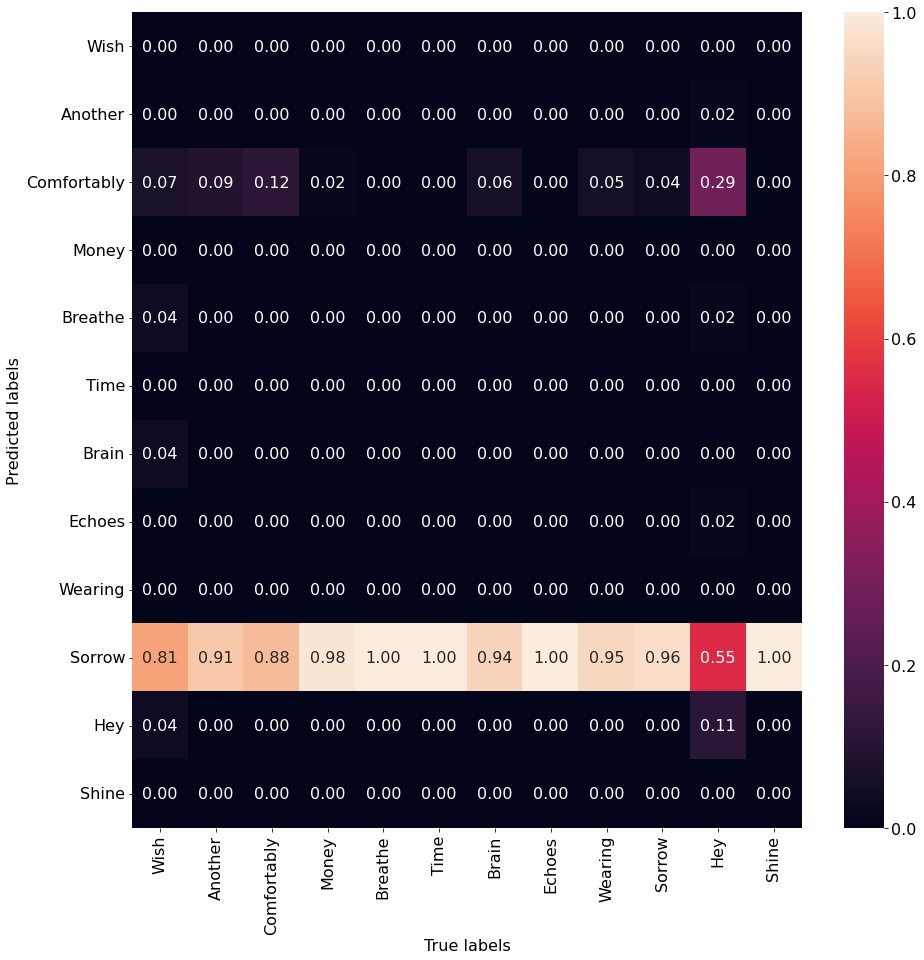

7/7 [==============================] - 0s 26ms/step
Accuracy: 0.3424657534246575
F1 score: 0.09105392156862746


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


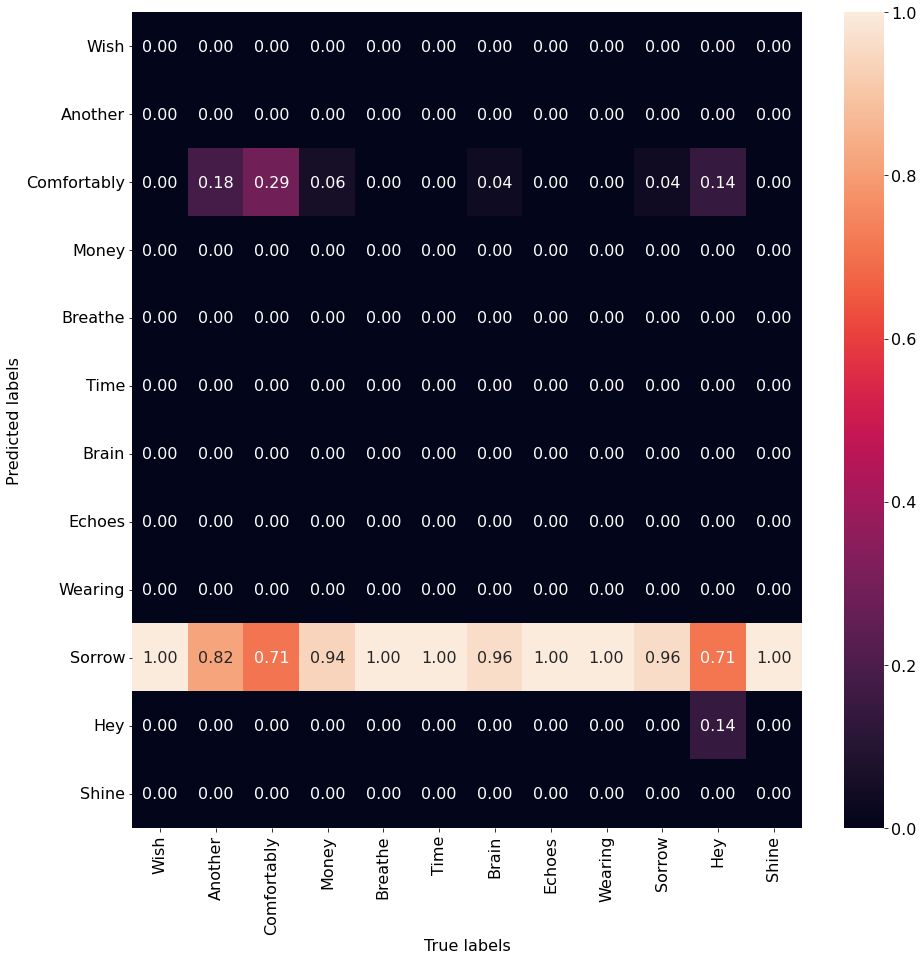

8/8 [==============================] - 1s 81ms/step
Accuracy: 0.32510288065843623
F1 score: 0.05106865897484395


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


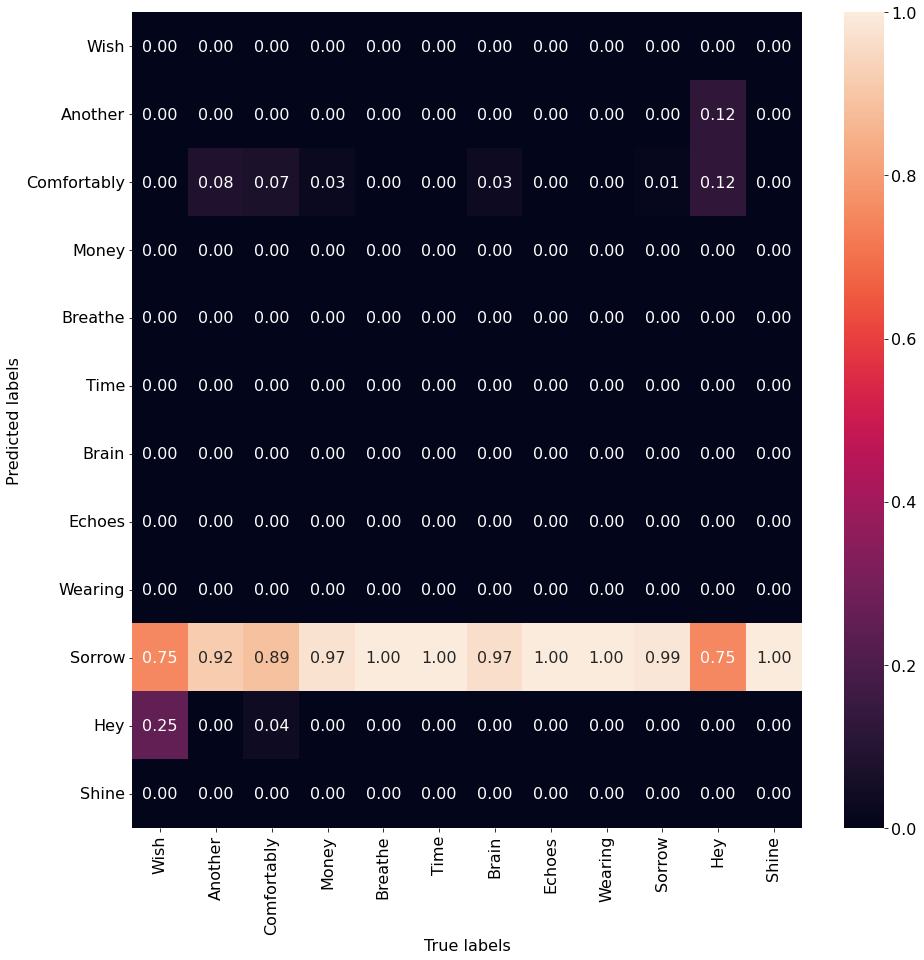

In [ ]:
ret = evaluate_model_m(eff, X_train, y_train, classes)
ret = evaluate_model_m(eff, X_val, y_val, classes)
ret = evaluate_model_m(eff, X_test, y_test, classes)